Data shape: (100000, 784) Labels: (100000,)
Logistic Regression Accuracy: 0.9177
Random Forest Accuracy: 0.9403
Extra Trees Accuracy: 0.9431
SVC Accuracy: 0.9567
Voting Classifier Accuracy: 0.9496

Best model: SVC with accuracy 0.9567


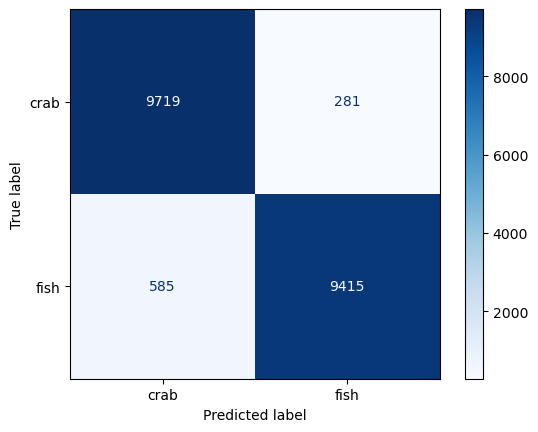

              precision    recall  f1-score   support

        crab       0.94      0.97      0.96     10000
        fish       0.97      0.94      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



['quickdraw_classes_50.joblib']

In [1]:
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.inspection import permutation_importance

# Settings
DATA_DIR = "quickdraw_simplified"
CATEGORIES = ["crab", "fish"]
IMG_SIZE = 28
N_PER_CLASS = 50000

# Load data from QuickDraw 
X, y = [], []
for idx, category in enumerate(CATEGORIES):
    file_path = os.path.join(DATA_DIR, f"{category}.npy")
    data = np.load(file_path)

    #
    data = data[:N_PER_CLASS]
    
    if data.ndim == 3:
        data = data.reshape(data.shape[0], -1)

    # Normalize
    data = data / 255.0

    X.append(data)
    y.extend([idx] * len(data))

# Stack
X = np.vstack(X)
y = np.array(y)
print("Data shape:", X.shape, "Labels:", y.shape)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1),
    "Extra Trees": ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "SVC": SVC(kernel='rbf', random_state=42, probability=True),
    "Voting Classifier": VotingClassifier([
        ("logreg", LogisticRegression(max_iter=1000, n_jobs=-1)),
        ("rf", RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)),
        ("et", ExtraTreesClassifier(n_estimators=1000, random_state=42, n_jobs=-1)),
        ("svc", SVC(kernel='rbf', random_state=42, probability=True))
    ], voting="soft", n_jobs=-1)
}

# Train and evaluate
best_name, best_model, best_acc = None, None, 0
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    print(f"{name} Accuracy: {score:.4f}")
    if score > best_acc:
        best_name, best_model, best_acc = name, model, score

print(f"\nBest model: {best_name} with accuracy {best_acc:.4f}")

# Results
y_pred = best_model.predict(X_test_scaled)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=CATEGORIES).plot(cmap="Blues")
plt.show()
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# Save
joblib.dump(best_model, "quickdraw_model_50.joblib")
joblib.dump(scaler, "quickdraw_scaler_50.joblib")
joblib.dump(CATEGORIES, "quickdraw_classes_50.joblib")